## Задание 1. A/B–тестирование

1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?

Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

In [1]:
import pandas as pd # Импортируем необходимые библиотеки
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from tqdm.auto import tqdm
import plotly.express as px
import plotly.subplots as sp
from scipy.stats import norm
from scipy.stats import bootstrap

#### EDA 

In [2]:
groups = pd.read_csv('Проект_2_groups.csv', sep = ';') #некорректное считывание без разделителя

In [3]:
group_add = pd.read_csv('Проект_2_group_add.csv')

In [4]:
checks = pd.read_csv('Проект_2_checks.csv', sep = ';') #некорректное считывание без разделителя

In [5]:
active_studs = pd.read_csv('Проект_2_active_studs.csv')

In [6]:
groups.head() # датасет с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [7]:
groups.shape #проверяем количество строк и столбцов

(74484, 2)

In [8]:
groups.dtypes #проверяем типы столбцов 

id      int64
grp    object
dtype: object

In [9]:
groups.isna().sum() #проверяем столбцы на пропущенные значения

id     0
grp    0
dtype: int64

In [10]:
group_add.head() #датасет с пользователями,который прислали спустя 2 дня после передачи данных

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [11]:
group_add.shape #проверяем количество строк и столбцов

(92, 2)

In [12]:
group_add.dtypes #проверяем типы столбцов 

id      int64
grp    object
dtype: object

In [13]:
group_add.isna().sum() #проверяем столбцы на пропущенные значения

id     0
grp    0
dtype: int64

In [14]:
checks.head()# датасет с информацией об оплатах пользователей в дни проведения эксперимента

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [15]:
checks.shape #проверяем количество строк и столбцов

(541, 2)

In [16]:
checks.dtypes #проверяем типы столбцов 

student_id      int64
rev           float64
dtype: object

In [17]:
checks.isna().sum() #проверяем столбцы на пропущенные значения

student_id    0
rev           0
dtype: int64

In [18]:
checks.student_id.nunique() # проверим, что каждый пользователь сделал по одному платежу

541

In [19]:
active_studs.head() #датасет с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [20]:
active_studs.shape #проверяем количество строк и столбцов. Это около 11% от общего количества студентов(74484)

(8341, 1)

In [21]:
active_studs.dtypes #проверяем типы столбцов 

student_id    int64
dtype: object

In [22]:
active_studs.isna().sum() #проверяем столбцы на пропущенные значения

student_id    0
dtype: int64

In [23]:
group_all = pd.concat([groups, group_add]) #Cоединим данные о пользователях после двух дней и изначальный список пользователей по группам
group_all.head(10)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
5,1803,B
6,1805,B
7,2067,A
8,2078,A
9,2080,B


In [24]:
dubl_group_all = group_all[group_all.duplicated ()] #Проверим на дубликаты
dubl_group_all #Повторяющихся строк нет

,id,grp


In [25]:
#Проверим совпадает суммарное количество пользователей в датасетах
groups.groupby('grp',as_index = False)\
      .agg({'grp':'count'})\
      .rename(columns = {'grp':'group_quantity'})#74484 Довольно большой разброс в размерах контрольной и тестовой групп (некорректное сплитование)

,group_quantity
0,14671
1,59813


In [26]:
group_add.groupby('grp',as_index = False)\
         .agg({'grp':'count'})\
         .rename(columns = {'grp':'group_quantity'}) #92

,group_quantity
0,22
1,70


Всего 74576 строк. Всё совпало.

Из датасета checks известно, что оплативших пользователей 541 человек. Узнаем все ли они были активны эти два дня

In [27]:
users_not_active = checks.query("student_id not in @active_studs.student_id").rename(columns = {'student_id':'id'})
users_not_active

,id,rev
1,3185,690.0
2,25973,690.0
3,26280,690.0
5,100645,630.0
6,102534,580.0
...,...,...
508,5291900,199.0
512,5331842,290.0
521,5486319,199.0
530,5562806,398.0


149 человек оплатили, но не заходили. Их мы не мудем учитывать в дальнейших расчётах. Возможно у них автоматически списались деньги,есть другие способы оплаты без посещения страницы или сбой.

In [28]:
group_all.query("id in @users_not_active.id").grp.value_counts() # Узнаем соотношение оплативших, но неактивных по группам.

B    120
A     29
Name: grp, dtype: int64

Собираем датасет для работы. Нам нужна вся информация(id, группа, оплата есть/нет) об активных пользователях, т.е 8341 человек(количество человек в active_studs).

In [29]:
checks = checks.rename(columns = {'student_id':'id'}) #Поменяем в checks и active_studs названия колонок для объединения датасетов
active_studs = active_studs.rename(columns = {'student_id':'id'})

In [30]:
active_group_all = active_studs.merge(group_all,how = 'left', on = 'id')
active_group_all.shape

(8341, 2)

In [31]:
active_group_all.head()

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


In [32]:
table_AB = active_group_all.merge(checks,how = 'left', on = 'id')
table_AB.shape

(8341, 3)

Посмотрим какое количество пользователей каждой из групп было активным во время проведения А/В теста

In [33]:
table_AB['grp'].value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [34]:
#Заменим на 0 все значения отсутствующие в колонке оплаты
table_AB=table_AB.fillna(0)

In [35]:
table_AB.head()

,id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


Прежде чем приступить к проверке статистической значимости различий в метриках между контрольной и экспериментальной группами озвучим нулевую и альтернативную гипотезы:
Нулевая гипотеза H0 - показатели не имеют значимых различий по группам;Альтернативная гипотеза H1 - показатели метрик статистически значимо отличаются.

Посчитаем сколько в сумме платежей пришло за эти два дня в контрольной и тестовой группах, а также количество платежей в каждой из групп

In [36]:
sum_pay = table_AB.groupby('grp', as_index = False)\
                  .agg({'rev':'sum'})\
                  .round(0)\
                  .rename(columns = {"rev":'sum_pay'})
sum_pay

,grp,sum_pay
0,A,72820.0
1,B,394974.0


In [37]:
#за два дня пользователи, которые зашли на сайти и совершили оплату
count_pay = table_AB.groupby('grp', as_index = False).agg({'rev':'count'}).rename(columns = {"rev":'count_pay'})
count_pay

,grp,count_pay
0,A,1538
1,B,6803


<AxesSubplot:xlabel='rev', ylabel='Count'>

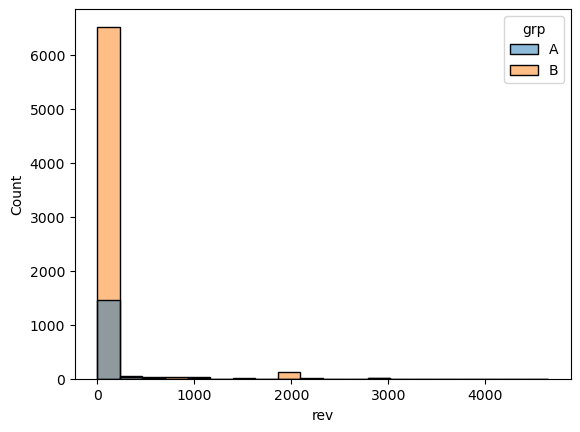

In [38]:
#Вид распределений пользователей активных во время АВ теста
sns.histplot(data=table_AB, x = 'rev', hue = 'grp', bins = 20)

In [39]:
ss.stats.normaltest(table_AB.query("grp == 'A'").rev) #Распределение ненормальное

C:\Users\Александр\AppData\Local\Temp\ipykernel_15280\1182451514.py:1: DeprecationWarning: Please use `normaltest` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  ss.stats.normaltest(table_AB.query("grp == 'A'").rev) #Распределение ненормальное


NormaltestResult(statistic=2240.5957974074026, pvalue=0.0)

In [40]:
ss.stats.normaltest(table_AB.query("grp == 'B'").rev) #Распределение ненормальное

C:\Users\Александр\AppData\Local\Temp\ipykernel_15280\155102351.py:1: DeprecationWarning: Please use `normaltest` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  ss.stats.normaltest(table_AB.query("grp == 'B'").rev) #Распределение ненормальное


NormaltestResult(statistic=7797.399211581946, pvalue=0.0)

In [41]:
table_AB_active = table_AB.query("rev > 0")

<AxesSubplot:xlabel='rev', ylabel='Count'>

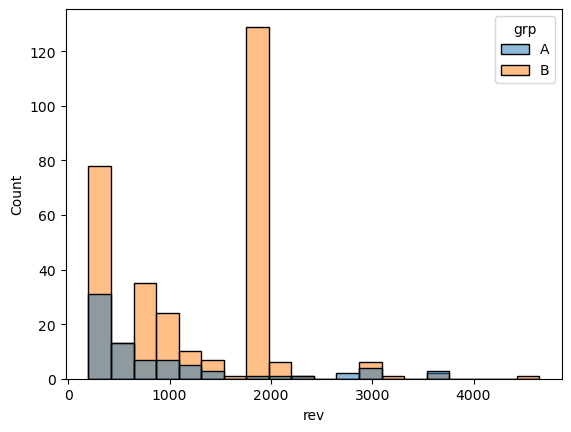

In [42]:
#Вид распределений пользователей активных во время АВ теста и совершивших оплату
sns.histplot(data=table_AB_active, x = 'rev', hue='grp', bins = 20)

In [43]:
ss.stats.normaltest(table_AB_active.query("grp == 'A'").rev) #Распределение ненормальное

C:\Users\Александр\AppData\Local\Temp\ipykernel_15280\311538750.py:1: DeprecationWarning: Please use `normaltest` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  ss.stats.normaltest(table_AB_active.query("grp == 'A'").rev) #Распределение ненормальное


NormaltestResult(statistic=30.378419638487458, pvalue=2.531686880422046e-07)

In [44]:
ss.stats.normaltest(table_AB_active.query("grp == 'B'").rev) #Распределение ненормальное

C:\Users\Александр\AppData\Local\Temp\ipykernel_15280\3006600277.py:1: DeprecationWarning: Please use `normaltest` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  ss.stats.normaltest(table_AB_active.query("grp == 'B'").rev) #Распределение ненормальное


NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

Из графика видно, что большие платежи были совершены пользователями из тестовой группы.

Проверим выбросы

<AxesSubplot:xlabel='grp', ylabel='rev'>

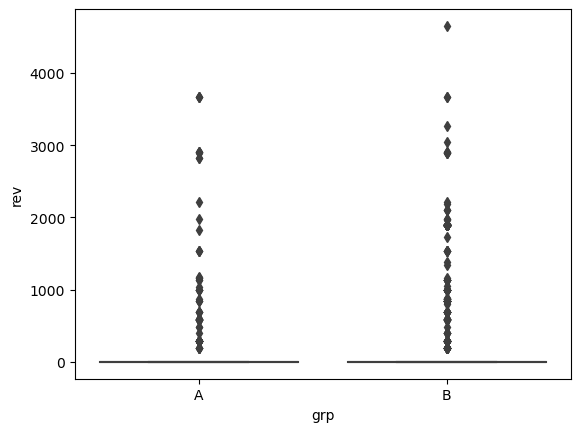

In [45]:
sns.boxplot(data = table_AB, x = 'grp', y = 'rev') #И в контрольной и тестовой группах есть выбросы

### Выбор метрик

Было выбрано 3 метрики:CR, ARPU, ARPPU. Все они связаны с измением дохода компании, что больше всего и интересует бизнес в первую очередь.
CR -  коэффициент конверсии в покупку (доля пользователей, которые совершили покупку от общего числа активных пользователей)/посмотрим как изменилась конверсия в покупку в тестовой группе по сравнению с контрольной;
ARPU - средняя прибыль от одного посетителя сайта;
ARPPU - средняя прибыль от одного платящего посетителя сайта.
Проведём расчёт указанных метрик:

In [46]:
ARPU = round(table_AB.groupby('grp', as_index = False)\
             .agg({'rev':'mean'})\
             .rename(columns = {"rev":'ARPU'}),2)
ARPU

,grp,ARPU
0,A,47.35
1,B,58.06


In [47]:
CR = round((table_AB.query('rev > 0').groupby('grp')\
                                   .agg({'id': 'count'}) / table_AB.groupby('grp')\
                                   .agg({'id': 'count'})) * 100, 2)\
                                   .rename(columns = {"id":'CR'})\
                                   .reset_index()
CR

,grp,CR
0,A,5.07
1,B,4.62


In [48]:
ARPPU = round(table_AB.query('rev>0')\
              .groupby('grp', as_index = False)\
              .agg({'rev':'mean'})\
              .rename(columns = {"rev":'ARPPU'}), 2)
ARPPU

,grp,ARPPU
0,A,933.59
1,B,1257.88


Произошло увеличение ARPU и ARPPU в тестовой группе. Возможно повысилась цена на товар или условия оплаты для пользователей стали более приятными и удобными. При это конверсия в покупку снизилась по сравнению с контрольной группой. Так как CR является категориальной переменной, то лучше использовать Xи-квадрат для проверки гипотезы(с использованием таблицы сопряжённости).Распределения ARPU и ARPPU ненормальные, есть выбросы. Использовать Манна-Уитни будет неразумно из-за часто повторяющихся данных. Поэтому будем использовать бутстрэп. Более точно можно будет определить границы доверительных интервалов и нет зависимости от нормальности распределения. Т-тест тоже не используем т.к распределения ненормальные.

### Гипотезы и проведение статистических тестов 

#### CR
Нулевая гипотеза (H0): При использовании новой механики оплаты не наблюдается значимого влияния на уровень конверсии в покупку (CR), изменения имеют  случайный характер\
Альтернативная гипотеза (H1): При использовании новой механики оплаты наблюдается статистически значимое влияние на снижение уровня конверсии в покупку (CR).

In [49]:
table_AB

,id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0
...,...,...,...
8336,1794344,B,0.0
8337,296883,B,0.0
8338,3598448,B,0.0
8339,3610547,B,290.0


In [50]:
table_AB['pay'] = table_AB['rev'] > 0 #добавляем столбец 'pay' для создания таблицы сопряжённости

In [51]:
table_AB

,id,grp,rev,pay
0,581585,A,0.0,False
1,5723133,A,0.0,False
2,3276743,B,0.0,False
3,4238589,A,0.0,False
4,4475369,B,0.0,False
...,...,...,...,...
8336,1794344,B,0.0,False
8337,296883,B,0.0,False
8338,3598448,B,0.0,False
8339,3610547,B,290.0,True


In [52]:
cross_table_CR = pd.crosstab(table_AB.grp, table_AB.pay)
cross_table_CR

pay,False,True
grp,,
A,1460,78
B,6489,314


In [53]:
ss.chi2_contingency(cross_table_CR)

(0.48480826522557896,
 0.48625240457231045,
 1,
 array([[1465.71897854,   72.28102146],
        [6483.28102146,  319.71897854]]))

Видим, что значение pvalue больше 0.05 и отклонить нулевую гипотезу нельзя. Между контрольной и тестовой группами в конверсии нет различий.

#### ARPPU

Нулевая гипотеза (H0): При использовании новой механики оплаты не наблюдается значимого влияния на увеличение ARPPU, изменения имеют случайный характер\
Альтернативная гипотеза (H1): При использовании новой механики оплаты наблюдается статистически значимое влияние на увеличение ARPPU.

In [54]:
bootstrap_ARPPU = table_AB[table_AB.rev != 0][['grp', 'rev']]

In [55]:
bootstrap_ARPPU_А = bootstrap_ARPPU.query('grp == "A"').rev
bootstrap_ARPPU_В = bootstrap_ARPPU.query('grp == "B"').rev

In [56]:
def get_bootstrap(
    bootstrap_ARPPU_А, # числовые значения первой выборки 
    bootstrap_ARPPU_B, # числовые значения второй выборки 
    boot_it, # количество бутстрэп-подвыборок
    statistic, # интересующая нас статистика
    bootstrap_conf_level # уровень значимости
):
    boot_len = max([len(bootstrap_ARPPU_А), len(bootstrap_ARPPU_B)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = bootstrap_ARPPU_А.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = bootstrap_ARPPU_B.sample(
            boot_len,
            replace = True
        ).values
        boot_data.append(statistic(samples_2-samples_1)) 
    
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2 # расчёт границ доверительного интервала
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data))
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2 # считаем p_value
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

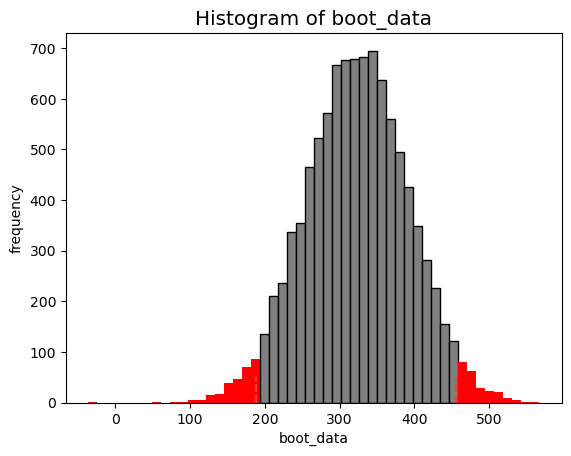

{'quants':                 0
 0.025  188.450807
 0.975  455.842686,
 'p_value': 2.5910961471400685e-06}

In [57]:
get_bootstrap(bootstrap_ARPPU_А, bootstrap_ARPPU_В, 10000, np.mean, 0.95)


0 не входит в доверительный интервал и p_value<0.05, отклоняем Н0 - ARPPU в группах различается

#### ARPU

Нулевая гипотеза (H0): При использовании новой механики оплаты не наблюдается значимого влияния на увеличение ARPU, изменения имеют случайный характер\
Альтернативная гипотеза (H1): При использовании новой механики оплаты наблюдается статистически значимое влияние на увеличение ARPU.

In [58]:
bootstrap_ARPU_А = table_AB.query('grp == "A"').rev
bootstrap_ARPU_B = table_AB.query('grp == "B"').rev

In [59]:
def get_bootstrap_1(
    bootstrap_ARPU_А, # числовые значения первой выборки 
    bootstrap_ARPU_B, # числовые значения второй выборки 
    boot_it, # количество бутстрэп-подвыборок
    statistic, # интересующая нас статистика
    bootstrap_conf_level # уровень значимости
):
    boot_len = max([len(bootstrap_ARPU_А), len(bootstrap_ARPU_B)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = bootstrap_ARPU_А.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = bootstrap_ARPU_B.sample(
            boot_len,
            replace = True
        ).values
        boot_data.append(statistic(samples_2-samples_1))
    
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2 # расчёт границ доверительного интервала
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data))
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2 # считаем p_value
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin = 0,ymax = 50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

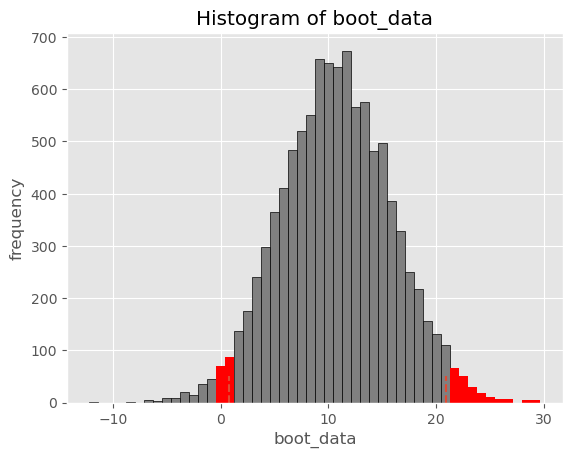

{'quants':                0
 0.025   0.761980
 0.975  20.889487,
 'p_value': 0.036984731773853065}

In [60]:
get_bootstrap_1(bootstrap_ARPU_А, bootstrap_ARPU_B, 10000, np.mean, 0.95)

0 не входит в доверительный интервал и p_value<0.05, отклоняем Н0 - ARPU в группах различается

#### Вывод:
Новая механика оплаты показала себя лучше, чем предыдущая. Есть статистически значимое повышение ARPPU, ARPU и статистически незначимое влияние на снижение конверсии в покупку. Новую мехнику стоит распространить на всех пользователей.

## Задание 2. SQL

### 2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

default.peas

![jupyter](./default.peas.JPG)

2.1.2 Задача

Посмотрим за какое количество месяцев у нас предоставлена информация 

In [61]:
#SELECT DISTINCT toStartOfMonth(timest) AS month_task       
#FROM default.peas    

Получается, что данные собраны за один месяц. Посчитаем количество усердных студентов.

In [62]:
#SELECT uniqExact(st_id) AS clever_student
#FROM
#(
#SELECT st_id,
#SUM(correct) AS correct_task
#FROM default.peas
#GROUP BY st_id
#HAVING correct_task >= 20
#)

Если хотим посмотреть кто из усердных студентов сколько заданий выполнил

In [63]:
#SELECT st_id,
#SUM(correct) AS correct_task
#FROM default.peas
#GROUP BY st_id
#HAVING correct_task >= 20

### 2.2 Оптимизация воронки

Даны таблицы: default.peas, default.studs, default.final_project_check:
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

    ARPU 
    ARPAU 
    CR в покупку 
    СR активного пользователя в покупку 
    CR пользователя из активности по математике (subject = 'math') в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

default.peas

![jupyter](./default.peas.JPG)

default.studs

![jupyter](./default_studs.JPG)

default.final_project_check

![jupyter](./default.final_project_check.JPG)

In [64]:
#SELECT
    #test_grp AS group,
    #SUM(sum_money) / uniqExact(st_id) AS ARPU,
    #SUMIf(sum_money, sum_correct > 10) / COUNTIf(sum_correct > 10) AS ARPAU,
    #COUNTIf(sum_money > 0) / uniqExact(st_id)* 100 AS CR_in_buy,
    #COUNTIf(sum_correct > 10 AND sum_money > 0) / COUNTIf(sum_correct > 10) * 100 AS CR_active_user_in_buy,
    #SUMIf(math_buy_course, sum_math_course >= 2) / COUNTIf(st_id, sum_math_course >= 2) * 100 AS CR_math_buy
#FROM
    #(SELECT * FROM default.studs AS left 
    #LEFT JOIN (SELECT DISTINCT st_id, SUM(correct) AS sum_correct,
    #SUMIf(correct, subject = 'Math') AS sum_math_course
    #FROM default.peas 
    #GROUP BY st_id) AS right USING st_id) AS k
    #LEFT JOIN
    #(SELECT
    #DISTINCT st_id,
    #SUM(money) AS sum_money,
    #COUNTIf(money, subject='Math') AS math_buy_course 
    #FROM default.final_project_check
    #GROUP BY st_id) AS p USING st_id
#GROUP BY test_grp

## Задание 3. Python

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Возьмём таблицу из первого задания table_AB, подготовленную для A/B теста

In [65]:
table_AB #аналогична таблице table_AB_1,представленной в функции ниже

,id,grp,rev,pay
0,581585,A,0.0,False
1,5723133,A,0.0,False
2,3276743,B,0.0,False
3,4238589,A,0.0,False
4,4475369,B,0.0,False
...,...,...,...,...
8336,1794344,B,0.0,False
8337,296883,B,0.0,False
8338,3598448,B,0.0,False
8339,3610547,B,290.0,True


In [66]:
def metrics_func (groups,group_add,active_studs,checks): #повторим шаги по формированию таблицы для АВ теста из 1 задания
    active_studs = active_studs.rename(columns = {'student_id':'id'})
    checks= checks.rename(columns = {'student_id':'id'})
    group_all = pd.concat([groups, group_add])
    active_group_all = active_studs.merge(group_all,how = 'left', on = 'id')
    table_AB_1 = active_group_all.merge(checks,how = 'left', on = 'id') #аналогична table_AB из задания 1.
    table_AB_1['pay'] = table_AB_1['rev'] > 0
    #необходимо посчитать сумму покупок,количество студентов и количество покупок в группах. Шаг с формированием переменной table AB указан в вопросе 1
    table_AB_1 = table_AB_1.groupby('grp', as_index = False) \
                          .agg(count_id = ('id', 'count'), 
                               Sum_pay = ('rev', lambda x: x[x > 0].count()), 
                               Sum_revenue = ('rev', 'sum'))
    #Расчёт метрик
    table_AB_1['CR'] = table_AB_1.Sum_pay*100 / table_AB_1.count_id
    table_AB_1['ARPAU'] = table_AB_1.Sum_revenue / table_AB_1.count_id
    table_AB_1['ARPPU'] = table_AB_1.Sum_revenue / table_AB_1.Sum_pay
    return table_AB_1

In [67]:
add_data_AB = metrics_func(groups, group_add, active_studs, checks)
add_data_AB

,grp,count_id,Sum_pay,Sum_revenue,CR,ARPAU,ARPPU
0,A,1538,78,72820.0000,5.071521,47.347204,933.589744
1,B,6803,314,394974.0035,4.615611,58.058798,1257.878992


In [68]:
def vizualization_metrics (data):
    fig, axes = plt.subplots(1, 3, figsize=(15, 6)) 
    sns.barplot(data = data, x = 'grp', y = 'CR', palette=["#6495ED", "#4CC9F0"], ax=axes[0]).set(title = 'CR', xlabel = 'group', ylabel = '')
    sns.barplot(data = data, x = 'grp', y = 'ARPAU', palette=["#6495ED", "#4CC9F0"], ax=axes[1]).set(title = 'ARPAU', xlabel = 'group', ylabel = '')
    sns.barplot(data = data, x = 'grp', y = 'ARPPU', palette=["#6495ED", "#4CC9F0"], ax=axes[2]).set(title = 'ARPPU', xlabel = 'group', ylabel = '')
    plt.show()

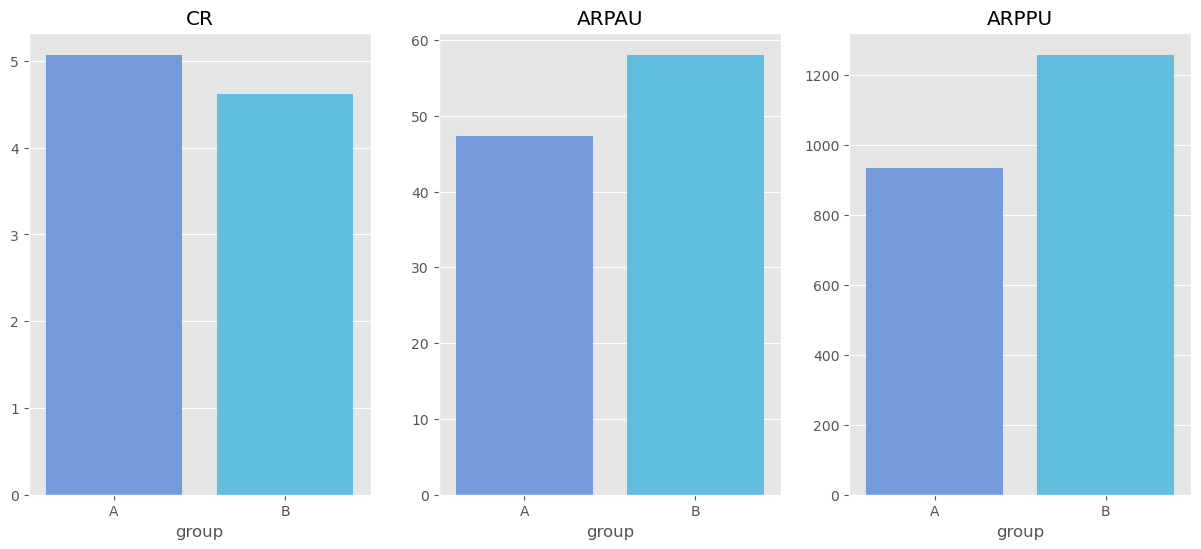

In [69]:
vizualization_metrics(add_data_AB)